## MIMIC-III Dataset

We used MIMIC-III data for this project as it is an open source dataset and contains multiple tables which can be combined to prepare use cases. Data can be accesed on link provided below and in order to access data, few certifications are required which can be obtained by completing trainings on website. 
Medical Information Mart for Intensive Care Unit (MIMIC) III: Open source dataset developed by the MIT Lab comprising de-identified health data is a comprehensive clinical dataset of 40,000+ patients admitted in ICU. Few salient features of this databases include:
- <b> 26 tables:</b> Comprehensive clinical dataset with different tables
- <b> 40,000+ patients:</b> Data associated with multiple admissions of patients
- <b> 65,000+ ICU admissions:</b> Admitted in ICUs at Beth Israel Deaconess Medical Centre, Boston, from 2001 to 2012
- <b> PII data:</b> Includes patient sensitive details like demographics, diagnosis, laboratory tests, medications etc.
- <b> Use cases:</b> Can be used for multiple analysis like clinical data (prescriptions), claims data (payer), members data (patient)

For this project, we focus on using specific tables from this database and create 2 different use cases to help in model compatibility evaluation for both regression as well as classification problem

The details of the use cases can be found in the following section.

Source: https://mimic.physionet.org/gettingstarted/overview/

## Use Cases

### Use Case 1: Length of Stay - 

Predicting the length of stay in ICU using 4 out of 26 tables


Use case: Out of variety of possible use cases from MIMIC III dataset we focus on single use case to predict the number of days a patient stays in the ICU to further generate synthetic data. This usecase seemed important to us because its always a benefit for payer to predict the tendency of the length of stay of a patient. It helps in changing the premium charged by the payer according to the comparison of predictions and baseline (the defined no. of days covered by a particular plan of the patient). For this use case the model utilises the total number of diagnosis that occured for different disease category for each patient.

To build this use case we focus on primarily 4 tables.

1. <b> Patients:</b> Every unique patient in the database (defines SUBJECT_ID) 
   <b> Columns like:</b> SUBJECT_ID, GENDER (count of rows: 46520 count of columns: 7)
2. <b> Admissions:</b> Every unique hospitalization for each patient in the database (defines HADM_ID)
   <b> Columns like:</b> SUBJECT_ID, HADM_ID, HOSPITAL_EXPIRE_FLAG, MARITAL_STATUS, ETHNICITY, ADMISSION_TYPE (count of rows: 58976 count of columns: 18 )
3. <b> ICUSTAYS:</b> Every unique ICU stay in the database (defines ICUSTAY_ID)
   <b> Columns like:</b> SUBJECT_ID, HADM_ID, LOS (count of rows: 61532 count of columns: 11 )
4. <b> Diagnosis_ICD:</b> Hospital assigned diagnoses, coded using the International Statistical Classification of Diseases and Related Health Problems (ICD) system
   <b> Columns like:</b> SUBJECT_ID, HADM_ID, NUMDIAGNOSIS (count of rows: 651047 count of columns: 5)

#### Methodology
1. <b> Load csv files:</b> Read the comma seperated files donwloaded from link (https://mimic.physionet.org/gettingstarted/overview/)
2. <b> Merge tables: </b> Use 'SUBJECT_ID' to merge tables like ADMISSIONS, PATIENTS and ICU_STAYS and finally concatenate 'SUBJECT_ID' and 'HADM_ID' to form 'final_id' as composite key.
3. <b> Prepare diagnosis dataset: </b> DIAGNOSIS_ICD table is used to map the disease category type using the first three code digits if ICD-9 code. The mapping is used to convert the unique 6984 ICD-9 codes into 18 different disease area categories and finally concatenate 'SUBJECT_ID' and 'HADM_ID' to form 'final_id' as composite key..
4. <b> Pivot up diagnosis dataset: </b> After the mapping the disease categories using ICD-9 codes, the datset is pivoted up at the level of the 18 disease categories and the total count of diagnosis is being populated across 'final_id'
5. <b> Merge pivoted diagnosis datset to the main dataset: </b> Finally, the above generated dataset is then merged to the main dataset using the 'final_id' as the key.

Note: 6984 ICD-9 codes: The diagnosis dataset contains unique International Classification of Disease (ICD-9) codes                                                                            
      18 primary categories: We consider categories of conditions for the predictive modeling
Finally only the relevant columns required for the analysis are selected and we use the dataset for the synthetic data generation.
The final data has 116354 rows and 27 columns.


#### Final data includes
- <b> Level of data:</b> Each instance in the final data set is unique admission for each patient and is defined by concatination of 'SUBJECT_ID' and 'HADM_ID' to form 'final_id'
- <b> Target Variables:</b> 'LOS' (length of stay) is used as target variable
- <b> Predictor variables:</b> 18 columns of different diagnosis category are used as predictor varibales.
        These 18 categories are:
        "certain conditions originating in the perinatal period"                      
        "complications of pregnancy, childbirth, and the puerperium",
        "congenital anomalies",                                                
        "diseases of the blood and blood-forming organs",                       
        "diseases of the circulatory system",                                   
        "diseases of the digestive system",                                     
        "diseases of the genitourinary system",                                 
        "diseases of the musculoskeletal system and connective tissue",         
        "diseases of the nervous system",                                       
        "diseases of the respiratory system",                                   
        "diseases of the sense organs",                                         
        "diseases of the skin and subcutaneous tissue",                         
        "endocrine, nutritional and metabolic diseases, and immunity disorders",                     
        "external causes of injury and supplemental classification",            
        "infectious and parasitic diseases",                                    
        "injury and poisoning",                                                 
        "mental disorders",                                                     
        "neoplasms" and                                                            
        "symptoms, signs, and ill-defined conditions".
- <b> Other descriptive variables:</b> "ADMISSION_TYPE", "MARITAL_STATUS","INSURANCE", "ETHNICITY", "HOSPITAL_EXPIRE_FLAG", "GENDER" and "EXPIRE_FLAG"
       


#### Code 
1. Import required libraries and read csv files
2. Function to roll up tables

#### 1. Import required libraries and read csv files

In [454]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [455]:

# Primary Admissions information
df = pd.read_csv(r"C:\Users\poona\Desktop\ELP\mimic-iii-clinical-database-1.4\mimic-iii-clinical-database-1.4\ADMISSIONS.csv")

# Patient specific info such as gender
df_pat = pd.read_csv(r"C:\Users\poona\Desktop\ELP\mimic-iii-clinical-database-1.4\mimic-iii-clinical-database-1.4\PATIENTS.csv")

# Diagnosis for each admission to hospital
df_diagcode = pd.read_csv(r"C:\Users\poona\Desktop\ELP\mimic-iii-clinical-database-1.4\mimic-iii-clinical-database-1.4\DIAGNOSES_ICD.csv")

# Intensive Care Unit (ICU) for each admission to hospital
df_icu = pd.read_csv(r"C:\Users\poona\Desktop\ELP\mimic-iii-clinical-database-1.4\mimic-iii-clinical-database-1.4\ICUSTAYS.csv")


## Patients dataset

In [456]:
print('Dataset has {} number of unique admission events.'.format(df['HADM_ID'].nunique()))
print('Dataset has {} number of unique patients.'.format(df['SUBJECT_ID'].nunique()))

Dataset has 58976 number of unique admission events.
Dataset has 46520 number of unique patients.


In [457]:
# Convert admission and discharge times to datatime type
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'])

# Calculating the Length of Stay variable using the difference between Discharge time and Admit time 
# Convert timedelta type into float 'days'. Note: There are 86400 seconds in a day
df['LOS'] = (df['DISCHTIME'] - df['ADMITTIME']).dt.total_seconds()/86400

In [458]:
df['LOS'].describe()

count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: LOS, dtype: float64

In [459]:
# Drop rows with negative LOS. The negative LOS means that the patient was brought dead to the ICU.
df['LOS'][df['LOS'] > 0].describe()

count    58878.000000
mean        10.151266
std         12.459774
min          0.001389
25%          3.755556
50%          6.489583
75%         11.805556
max        294.660417
Name: LOS, dtype: float64

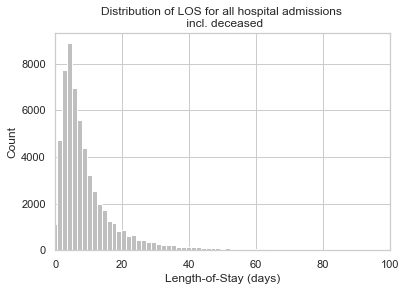

In [460]:
# Plot LOS Distribution
plt.hist(df['LOS'], bins=200, color = '0.75')
plt.xlim(0, 100)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

In [461]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,1.144444
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,5.496528
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,6.768056
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,2.856944
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,3.534028


In [462]:
# Drop LOS < 0 
df = df[df['LOS'] > 0]

In [463]:
# Dropping the columns that are not needed
df.drop(columns=['DISCHTIME', 'ROW_ID', 
                'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG',
                'HAS_CHARTEVENTS_DATA'], inplace=True)

In [464]:
# Mapping the dead and alive value of patients who died in hospital as 1 and 0
df['DECEASED'] = df['DEATHTIME'].notnull().map({True:1, False:0})

In [465]:
print("{} of {} patients died in the hospital".format(df['DECEASED'].sum(), 
                                                     df['SUBJECT_ID'].nunique()))

5774 of 46445 patients died in the hospital


In [466]:
# Descriptive analysis of patients who died during the stay in ICU
df['LOS'].loc[df['DECEASED'] == 0].describe()

count    53104.000000
mean        10.138174
std         12.284461
min          0.014583
25%          3.866667
50%          6.565972
75%         11.711632
max        294.660417
Name: LOS, dtype: float64

In [467]:
# Descriptive analysis of LOS metric (target variable)
mean_los = df['LOS'].mean() 
median_los = df['LOS'].median()
min_los = df['LOS'].min()
max_los = df['LOS'].max()

print("Mean LOS: ",mean_los)
print("Median LOS: ",median_los)
print("Min LOS: ",min_los)
print("Max LOS: ",max_los)

Mean LOS:  10.151266378028323
Median LOS:  6.489583333333333
Min LOS:  0.0013888888888888892
Max LOS:  294.66041666666666


In [468]:
# Club the Ethnicity categories into 5 broad categories
df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
df['ETHNICITY'].loc[~df['ETHNICITY'].isin(df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
df['ETHNICITY'].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


WHITE                     41268
OTHER/UNKNOWN              7700
BLACK/AFRICAN AMERICAN     5779
HISPANIC/LATINO            2125
ASIAN                      2006
Name: ETHNICITY, dtype: int64

#### 2. Function to plot graphs for exploratory analysis

In [469]:
# Bar plot function
def plot_los_groupby(variable, size=(7,4)):
    ''' 
    Plot Median LOS by df categorical series name 
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show();
    
# Boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    ''' 
    Boxplot of LOS by df categorical series name 
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df['LOS'].loc[df[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();



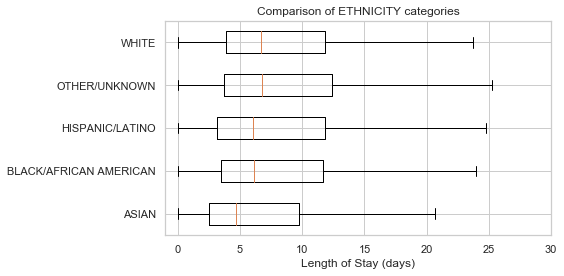

In [470]:
boxplot_los_groupby('ETHNICITY', los_range=(-1, 30))

## Admission Dataset

### Admission Type

In [471]:
df['ADMISSION_TYPE'].value_counts()

EMERGENCY    41989
NEWBORN       7854
ELECTIVE      7702
URGENT        1333
Name: ADMISSION_TYPE, dtype: int64

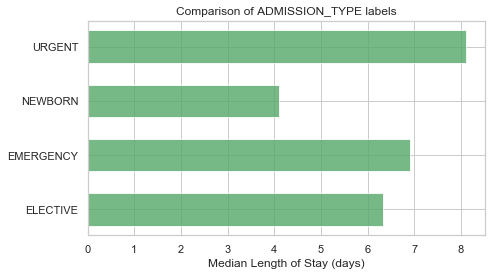

In [472]:
plot_los_groupby('ADMISSION_TYPE')

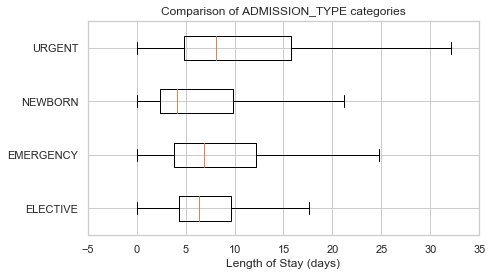

In [473]:
boxplot_los_groupby('ADMISSION_TYPE', los_range=(-5, 35), size=(7, 4))

### Insurance

In [474]:
df['INSURANCE'].value_counts()

Medicare      28174
Private       22542
Medicaid       5778
Government     1781
Self Pay        603
Name: INSURANCE, dtype: int64

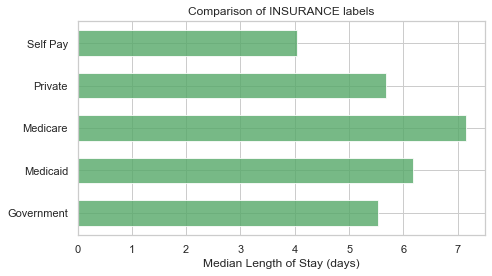

In [475]:
plot_los_groupby('INSURANCE')

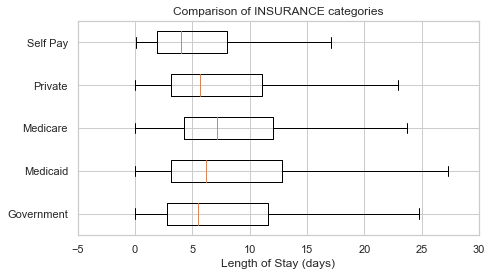

In [476]:
boxplot_los_groupby('INSURANCE', los_range=(-5, 30), size=(7, 4))

### Marital Status

In [477]:
df['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              24199
SINGLE               13238
NaN                  10097
WIDOWED               7204
DIVORCED              3211
SEPARATED              571
UNKNOWN (DEFAULT)      343
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

In [478]:
# Replacing NAs as'UNKNOWN'
df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
df['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              24199
SINGLE               13238
UNKNOWN (DEFAULT)    10440
WIDOWED               7204
DIVORCED              3211
SEPARATED              571
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

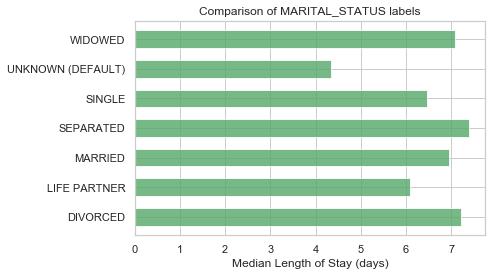

In [479]:
plot_los_groupby('MARITAL_STATUS')

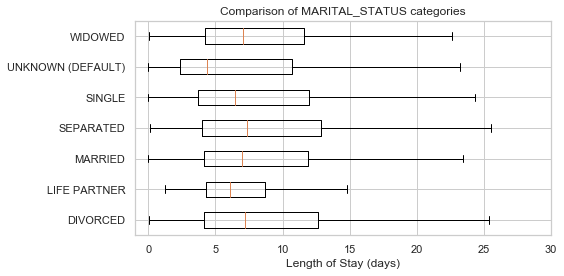

In [480]:
boxplot_los_groupby('MARITAL_STATUS')

## Diagnosis Dataset

Because it's not feasible to have 6985 unique values to use as features for predicting LOS, The diagnosis were reduced into more general categories. After researching the ICD9 coding methodology, the super categories in which the diagnosis codes are arranged are as follows:

- 001–139: infectious and parasitic diseases
- 140–239: neoplasms
- 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
- 280–289: diseases of the blood and blood-forming organs
- 290–319: mental disorders
- 320–389: diseases of the nervous system and sense organs
- 390–459: diseases of the circulatory system
- 460–519: diseases of the respiratory system
- 520–579: diseases of the digestive system
- 580–629: diseases of the genitourinary system
- 630–679: complications of pregnancy, childbirth, and the puerperium
- 680–709: diseases of the skin and subcutaneous tissue
- 710–739: diseases of the musculoskeletal system and connective tissue
- 740–759: congenital anomalies
- 760–779: certain conditions originating in the perinatal period
- 780–799: symptoms, signs, and ill-defined conditions
- 800–999: injury and poisoning
- E and V codes: external causes of injury and supplemental classification, using 999 as placeholder even though it overlaps with complications of medical care

Source of these categories: https://en.wikipedia.org/wiki/List_of_ICD-9_codes

In [481]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['recode'] = df_diagcode['ICD9_CODE']
df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diagcode['recode'].fillna(value='999', inplace=True)

In [482]:
df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
df_diagcode['recode'] = df_diagcode['recode'].astype(int)

In [483]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0],cat_range[1]), 
            num, df_diagcode['recode'])
    
# Convert integer to category name using diag_dict
df_diagcode['recode'] = df_diagcode['recode']
df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)

In [484]:
# Create list of diagnoses for each admission
hadm_list = df_diagcode.groupby('HADM_ID')['cat'].apply(list).reset_index()

In [485]:
# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).sum(level=0)

In [486]:
# Join the above created dataset using HADM_ID to the hadm_list
hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")

In [487]:
# Finally merging with main admissions df
df = df.merge(hadm_item, how='inner', on='HADM_ID')

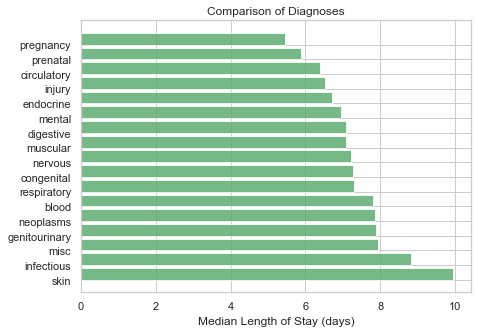

In [488]:
# Explore median LOS by diagnosis category as defined above
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory', 
                  'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal',  'pregnancy']

results = []
for variable in diag_cat_list:
    results.append(df[[variable, 'LOS']].groupby(variable).median().reset_index().values[1][1])

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, align='edge', color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Median Length of Stay (days)')
ax.tick_params(left=False, right=False, top=False) 
ax.set_title('Comparison of Diagnoses'.format(variable))
plt.show();

## Patients dataset

In [489]:
df_pat['GENDER'].value_counts()

M    26121
F    20399
Name: GENDER, dtype: int64

In [490]:
df_pat['GENDER'].replace({'M': 0, 'F':1}, inplace=True)

In [491]:
df = df.merge(df_pat, how='inner', on='SUBJECT_ID')

## ICU STAYS dataset

In [492]:
df_icu['HADM_ID'].nunique()

57786

In [493]:
df_icu.groupby('FIRST_CAREUNIT').median()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_WARDID,LAST_WARDID,LOS
FIRST_CAREUNIT,,,,,,,
CCU,29091.5,22964.5,150074.5,249373.5,7.0,7.0,2.19775
CSRU,31002.5,24488.0,150225.0,250492.0,14.0,14.0,2.15290
MICU,33612.5,26489.5,150368.0,250524.0,50.0,50.0,2.09550
NICU,19581.5,15456.5,149206.5,249308.0,56.0,56.0,0.80250
SICU,38089.0,30084.0,149744.0,248649.0,33.0,33.0,2.25220
TSICU,36382.0,28716.0,148915.0,250685.0,14.0,14.0,2.11150


In [494]:
# Converting different categories of first care unit into ICU and NICU groups
df_icu['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)

In [495]:
df_icu['cat'] = df_icu['FIRST_CAREUNIT']
icu_list = df_icu.groupby('HADM_ID')['cat'].apply(list).reset_index()

In [496]:
df_icu['FIRST_CAREUNIT'].value_counts()

ICU     53432
NICU     8100
Name: FIRST_CAREUNIT, dtype: int64

In [497]:
# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).sum(level=0)
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")

In [498]:
# Merge ICU data with main dataFrame
df = df.merge(icu_item, how='outer', on='HADM_ID')

In [499]:
# Replace NA with 0
df['ICU'].fillna(value=0, inplace=True)
df['NICU'].fillna(value=0, inplace=True)

## Final preparation of the dataset

In [501]:
# Drop unnecessary columns
df.drop(columns=['ADMISSION_LOCATION','SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_LOCATION',
                'DISCHARGE_LOCATION', 'LANGUAGE',
                'DIAGNOSIS', 'DECEASED',  'DEATHTIME'], inplace=True)
 df.drop(columns=['DOB','DOD','DOD_HOSP','DOD_SSN','ROW_ID','RELIGION'], inplace=True)

In [503]:
# Filtering only admission with LOS less than 40 days to reduce the skewness of the data.
df = df[df['LOS'] <40]

In [511]:
# Randomly splitting the data into test and train with 20% and 80% distribution. Using the train data to generate
# synthetic data and keeping the test data seperate for evaluation purpose

los_use, los_predict = train_test_split(df, test_size=0.2, random_state=25)

In [512]:
# Writing the train and test files into csv for further use 
# Note: Train dataset will be used for generating synthetic data using T-GAN and CT-GAN.
# Test dataset will be used for evaluation of models

los_use.to_csv("los_usecase.csv",index = False)
los_predict.to_csv("los_predict.csv",index = False)